In [1]:
import chess
import numpy as np

In [2]:
def getCastlingRights(board):
    rights = [
        board.has_kingside_castling_rights(chess.WHITE),
        board.has_queenside_castling_rights(chess.WHITE),
        board.has_kingside_castling_rights(chess.BLACK),
        board.has_queenside_castling_rights(chess.BLACK)
    ]
    
    res = 0
    coeff = 1
    for r in rights:
        if r:
            res += coeff
        coeff *= 2
    
    return res

def encodeBoard(fen):
    res = np.zeros((11, 11, 1))
    board = chess.Board(fen)
    
    for rank in range(8):
        for file in range(8):
            square = file + (8 * rank)
            piece_type = board.piece_type_at(square)
            if piece_type == None:
                continue
            else:
                piece_color = board.color_at(square)
                res[rank][file] = -piece_type if piece_color == chess.BLACK else piece_type
    
    c_rights = getCastlingRights(board)
    for i in range (8):
        res[8][i] = c_rights
        res[9][i] = board.ep_square if board.ep_square != None else 0
        res[10][i] = board.turn == chess.WHITE
    
    return res

In [3]:
import tensorflow as tf

from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


In [4]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(11, 11, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (2, 2), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1))
model.summary()
model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 9, 9, 32)          320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 4, 4, 32)          0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 3, 3, 64)          8256      
_________________________________________________________________
flatten (Flatten)            (None, 576)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                36928     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 45,569
Trainable params: 45,569
Non-trainable params: 0
____________________________________________________

In [5]:
import sys
sys.path.insert(1, '../Classes/')
from ScoreGetter import ScoreGetter
import pandas as pd
from sklearn.model_selection import train_test_split

df = pd.read_csv('/Volumes/HDD/IA/Deep_ViCTORIA/Datasets/raw_dataset.csv', nrows=100000)
score_getter = ScoreGetter('/usr/local/bin/stockfish', 'eval', 'go depth 1')

In [6]:
encoded = []
scores = []
for fen in df['board'].values:
    try:
        scores.append(score_getter.getScore(fen))
        encoded.append(encodeBoard(fen))
    except Exception as e: 
        if str(e) == '[Errno 32] Broken pipe':
            score_getter.restart()
        continue
encoded = np.array(encoded)
scores = np.array(scores)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(
                encoded, scores, test_size=0.33, random_state=42)

In [8]:
history = model.fit(X_train, y_train, epochs=10, 
                    validation_data=(X_test, y_test))

Epoch 1/10
2079/2079 [==============================] - 5s 2ms/step - loss: 346.9218 - accuracy: 0.0026 - val_loss: 284.3354 - val_accuracy: 0.0028
Epoch 2/10
2079/2079 [==============================] - 5s 2ms/step - loss: 277.2690 - accuracy: 0.0026 - val_loss: 264.3106 - val_accuracy: 0.0027
Epoch 3/10
2079/2079 [==============================] - 5s 2ms/step - loss: 266.5383 - accuracy: 0.0025 - val_loss: 265.5287 - val_accuracy: 0.0030
Epoch 4/10
2079/2079 [==============================] - 5s 2ms/step - loss: 261.0634 - accuracy: 0.0026 - val_loss: 259.8193 - val_accuracy: 0.0029
Epoch 5/10
2079/2079 [==============================] - 5s 2ms/step - loss: 259.3934 - accuracy: 0.0026 - val_loss: 268.9774 - val_accuracy: 0.0032
Epoch 6/10
2079/2079 [==============================] - 5s 2ms/step - loss: 256.7443 - accuracy: 0.0026 - val_loss: 266.7389 - val_accuracy: 0.0029
Epoch 7/10
2079/2079 [==============================] - 5s 2ms/step - loss: 254.4646 - accuracy: 0.0026 - val_lo

1024/1024 - 1s - loss: 244.4035 - accuracy: 0.0029


0.00286865234375

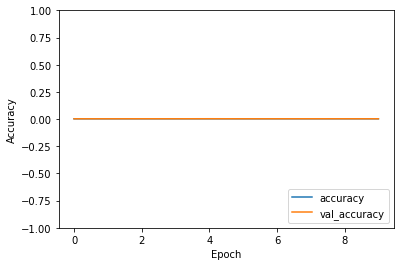

In [9]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([-1, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(X_test,  y_test, verbose=2)
test_acc

In [10]:
def plotPred (y_true, preds):
    ymin = np.min(y_true)
    ymax = np.max(y_true)
    plt.scatter(y_true, preds, label=f'score: {r2_score(y_true, preds)}')
    plt.plot([ymin, ymax], [ymin, ymax], '-.', color='red', label="predicted values = true values")
    plt.xlabel('True values')
    plt.ylabel('Predicted values')
    plt.legend()
    
def r2_score (y_true, preds):
    return 1 - (np.sum(np.square(preds - y_true)) / np.sum(np.square(preds - np.mean(preds))))

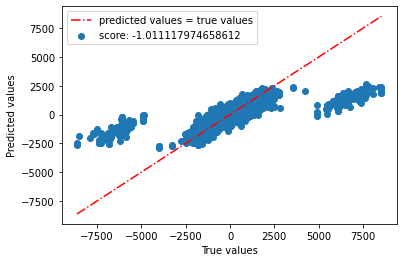

In [11]:
preds = model.predict(X_test).flatten()
plotPred (y_test, preds)